1: Загрузка библиотек и предобратка данных

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('csvfiles/employee.csv')

df["exceeds_monthly_hours_threshold"] = np.where(df["average_montly_hours"] >= 160, 1, 0).astype(int)
df.exceeds_monthly_hours_threshold = df.exceeds_monthly_hours_threshold.astype('category')
df.left = df.left.astype("category")
df.number_project = df.number_project.astype("category")
df.time_spend_company = df.time_spend_company.astype("category")
df.Work_accident = df.Work_accident.astype("category")
df.promotion_last_5years = df.promotion_last_5years.astype("category")

In [131]:
Y = df['exceeds_monthly_hours_threshold'] # выбираем целевую переменную (категориальную)
X = df.drop('exceeds_monthly_hours_threshold', axis=1) # переменные для проверки влияния

In [132]:
X = X.drop('average_montly_hours', axis=1)
df.drop('average_montly_hours', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   satisfaction_level               14999 non-null  float64 
 1   last_evaluation                  14999 non-null  float64 
 2   number_project                   14999 non-null  category
 3   time_spend_company               14999 non-null  category
 4   Work_accident                    14999 non-null  category
 5   promotion_last_5years            14999 non-null  category
 6   department                       14999 non-null  object  
 7   salary                           14999 non-null  object  
 8   left                             14999 non-null  category
 9   exceeds_monthly_hours_threshold  14999 non-null  category
dtypes: category(6), float64(2), object(2)
memory usage: 557.8+ KB


In [133]:
category_columns: list[str] = X.select_dtypes(include=['category', 'object']).columns # собираем колонки помеченные как catego

In [134]:
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарно

1.2 Проверка баланса

Проверка, насколько сбалансированы классы в нашей целевой переменной:

In [135]:
Y.value_counts()

exceeds_monthly_hours_threshold
1    10795
0     4204
Name: count, dtype: int64

1.3 Создание искусственного дисбаланса классов

Создадим новую целевую переменную y_disbalanced, где 90% классов будут 0, а 10% — 1:

In [136]:
from sklearn.utils import resample

# Объединяем X и Y для удобства
data = pd.concat([X, Y], axis=1)

# Разделяем на классы
minority = data[data['exceeds_monthly_hours_threshold'] == 0]
majority = data[data['exceeds_monthly_hours_threshold'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(
    minority,
    replace=False,
    n_samples=int(len(majority)*0.1),
    random_state=42,
)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и Y
X_disbalanced = data_disbalanced.drop('exceeds_monthly_hours_threshold', axis=1)
Y_disbalanced = data_disbalanced['exceeds_monthly_hours_threshold']

In [137]:
print(Y_disbalanced.value_counts())

exceeds_monthly_hours_threshold
1    10795
0     1079
Name: count, dtype: int64


1.4 Обучаем логистическую регрессию (без доп. манипуляций) на дисбалансе

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, Y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)


In [139]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.92843109738984

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.34      0.48       345
           1       0.93      0.99      0.96      3218

    accuracy                           0.93      3563
   macro avg       0.87      0.67      0.72      3563
weighted avg       0.92      0.93      0.92      3563



In [140]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1

{np.int64(0): np.int64(148), np.int64(1): np.int64(3415)}

1.5 Создадим сбалансированную выборку, и попробуем сделать тоже самое

In [141]:
# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('exceeds_monthly_hours_threshold', axis=1)
Y_balanced = data_balanced['exceeds_monthly_hours_threshold']

print(Y_balanced.value_counts())

exceeds_monthly_hours_threshold
0    4204
1    4204
Name: count, dtype: int64


In [142]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, Y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

     

print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.6785572730875942

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.56      0.63      1248
           1       0.65      0.79      0.71      1275

    accuracy                           0.68      2523
   macro avg       0.69      0.68      0.67      2523
weighted avg       0.69      0.68      0.67      2523



In [143]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить
     

{np.int64(0): np.int64(963), np.int64(1): np.int64(1560)}

In [144]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, Y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

In [145]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))

Accuracy: 0.6785572730875942

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.56      0.63      1248
           1       0.65      0.79      0.71      1275

    accuracy                           0.68      2523
   macro avg       0.69      0.68      0.67      2523
weighted avg       0.69      0.68      0.67      2523



2.6 А теперь до делу (вернемся к прошлым примерам и проанализуем нашу ситуацию)

In [146]:
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
)

# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, Y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)

     

# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}

In [147]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.73      0.56      0.63      1248
           1       0.65      0.79      0.71      1275

    accuracy                           0.68      2523
   macro avg       0.69      0.68      0.67      2523
weighted avg       0.69      0.68      0.67      2523



In [148]:
conf_matrix # Матрица
# TP TN
# FP FN 

array([[ 700,  548],
       [ 263, 1012]])

In [149]:
rounded_items

{'True Negatives (TN)': np.int64(700),
 'False Positives (FP)': np.int64(548),
 'False Negatives (FN)': np.int64(263),
 'True Positives (TP)': np.int64(1012),
 'Accuracy': 0.68,
 'Precision': np.float64(0.65),
 'Recall': np.float64(0.79),
 'F1-score': np.float64(0.71),
 'ROC-AUC': np.float64(0.68)}

⏰
TN - красные как красные
FP - красные как зеленые
FN - зеленые как красные
TP - зеленые как зеленые
Accuracy - доля верных предсказаний среди всех (из всех 100 яблок предсказаны верно 68)
Precision - доля верных положительных предказаний среди предсказанных положительных
(из 100 предсказанных зеленых, правильно отнесенные только 65)
Recall - доля правильно предсказанных, среди всех настоящих(из 100 всех зеленых, прелсказал 79 правльно)
F1-score - баланс между Precision и Recall
ROC-AUC - общая способность модели различать зеленые и красные

3. Задача мультиклассовой классфикации

In [150]:


y = df['average_montly_hours']

X = df.drop(['average_montly_hours', 'exceeds_monthly_hours_threshold'], axis=1)
     

# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category', 'object']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.

     


In [151]:
X

,satisfaction_level,last_evaluation,number_project_3,number_project_4,number_project_5,number_project_6,number_project_7,time_spend_company_3,time_spend_company_4,time_spend_company_5,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,left_1
0,0.38,0.53,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,True,False,True
1,0.80,0.86,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,True
2,0.11,0.88,False,False,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,True,True
3,0.72,0.87,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,True
4,0.37,0.52,False,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True
14995,0.37,0.48,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True
14996,0.37,0.53,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True
14997,0.11,0.96,False,False,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True



3.1 Алгоритм дерева принятия решений

Алгоритм дерева принятия решений (Decision Tree) — это один из методов машинного обучения, который используется для решения задач классификации и регрессии. Дерево решений представляет собой структуру, в которой каждый внутренний узел соответствует некоторому признаку, а каждая ветвь — определенному значению этого признака. Листовые узлы представляют собой классы или значения, которые необходимо предсказать.
Как работает дерево решений:

    Корневой узел: Это первый узел в дереве, который соответствует самому информативному признаку. Признак выбирается на основе критериев, например по индексу Gini (различие по y, чем ближе к 1, тем разнороднее классы y в узле)

    Разбиение данных: На каждом шаге дерево разбивает данные на подмножества в соответствии с выбранным признаком. Эти разбиения происходят рекурсивно, пока не будет достигнут некоторый критерий остановки (например, максимальная глубина дерева, минимальное количество данных в листе).

    Листовые узлы: Листовые узлы содержат финальные предсказания. В случае задачи классификации это будет класс, а в случае регрессии — числовое значение.

    Критерии остановки: Дерево останавливает разбиение, если достигается один из критериев остановки — например, если достигнута максимальная глубина дерева или в узле осталось меньше минимального числа данных для разбиения.

Преимущества:

    Простота визуализации и интерпретации.
    Может использоваться как для классификации, так и для регрессии.
    Не требует предварительной нормализации данных.

Недостатки:

    Может переобучаться (overfitting), если не ограничить глубину дерева.
    Чувствительно к небольшим изменениям в данных.

In [152]:


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)
     


print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))

     



Classification Report:
               precision    recall  f1-score   support

          96       0.00      0.00      0.00         3
          97       0.00      0.00      0.00         5
          98       0.00      0.00      0.00        10
          99       0.00      0.00      0.00         1
         100       0.25      0.12      0.17         8
         101       0.00      0.00      0.00         7
         102       0.00      0.00      0.00         6
         103       0.00      0.00      0.00         6
         104       1.00      0.10      0.18        10
         105       0.00      0.00      0.00         3
         106       0.50      0.17      0.25         6
         107       0.00      0.00      0.00         2
         108       0.00      0.00      0.00         4
         109       0.00      0.00      0.00         5
         110       0.00      0.00      0.00         3
         111       0.00      0.00      0.00         8
         112       0.00      0.00      0.00         3
  

/Users/levlazutin/Library/Caches/pypoetry/virtualenvs/mlvvsu-Cozse6Tr-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/levlazutin/Library/Caches/pypoetry/virtualenvs/mlvvsu-Cozse6Tr-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/levlazutin/Library/Caches/pypoetry/virtualenvs/mlvvsu-Cozse6Tr-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

In [153]:
accuracy_score(y_test_multi, y_pred_multi)

0.04133333333333333

In [154]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну очень такое

np.float64(0.040170570905889214)

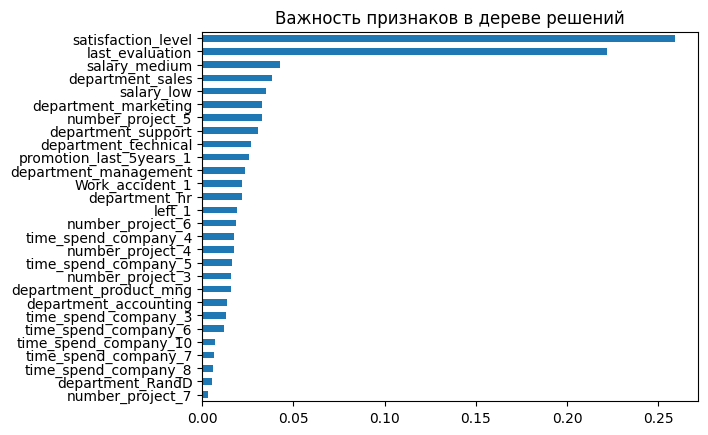

In [155]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Важность признаков в дереве решений')
plt.show()

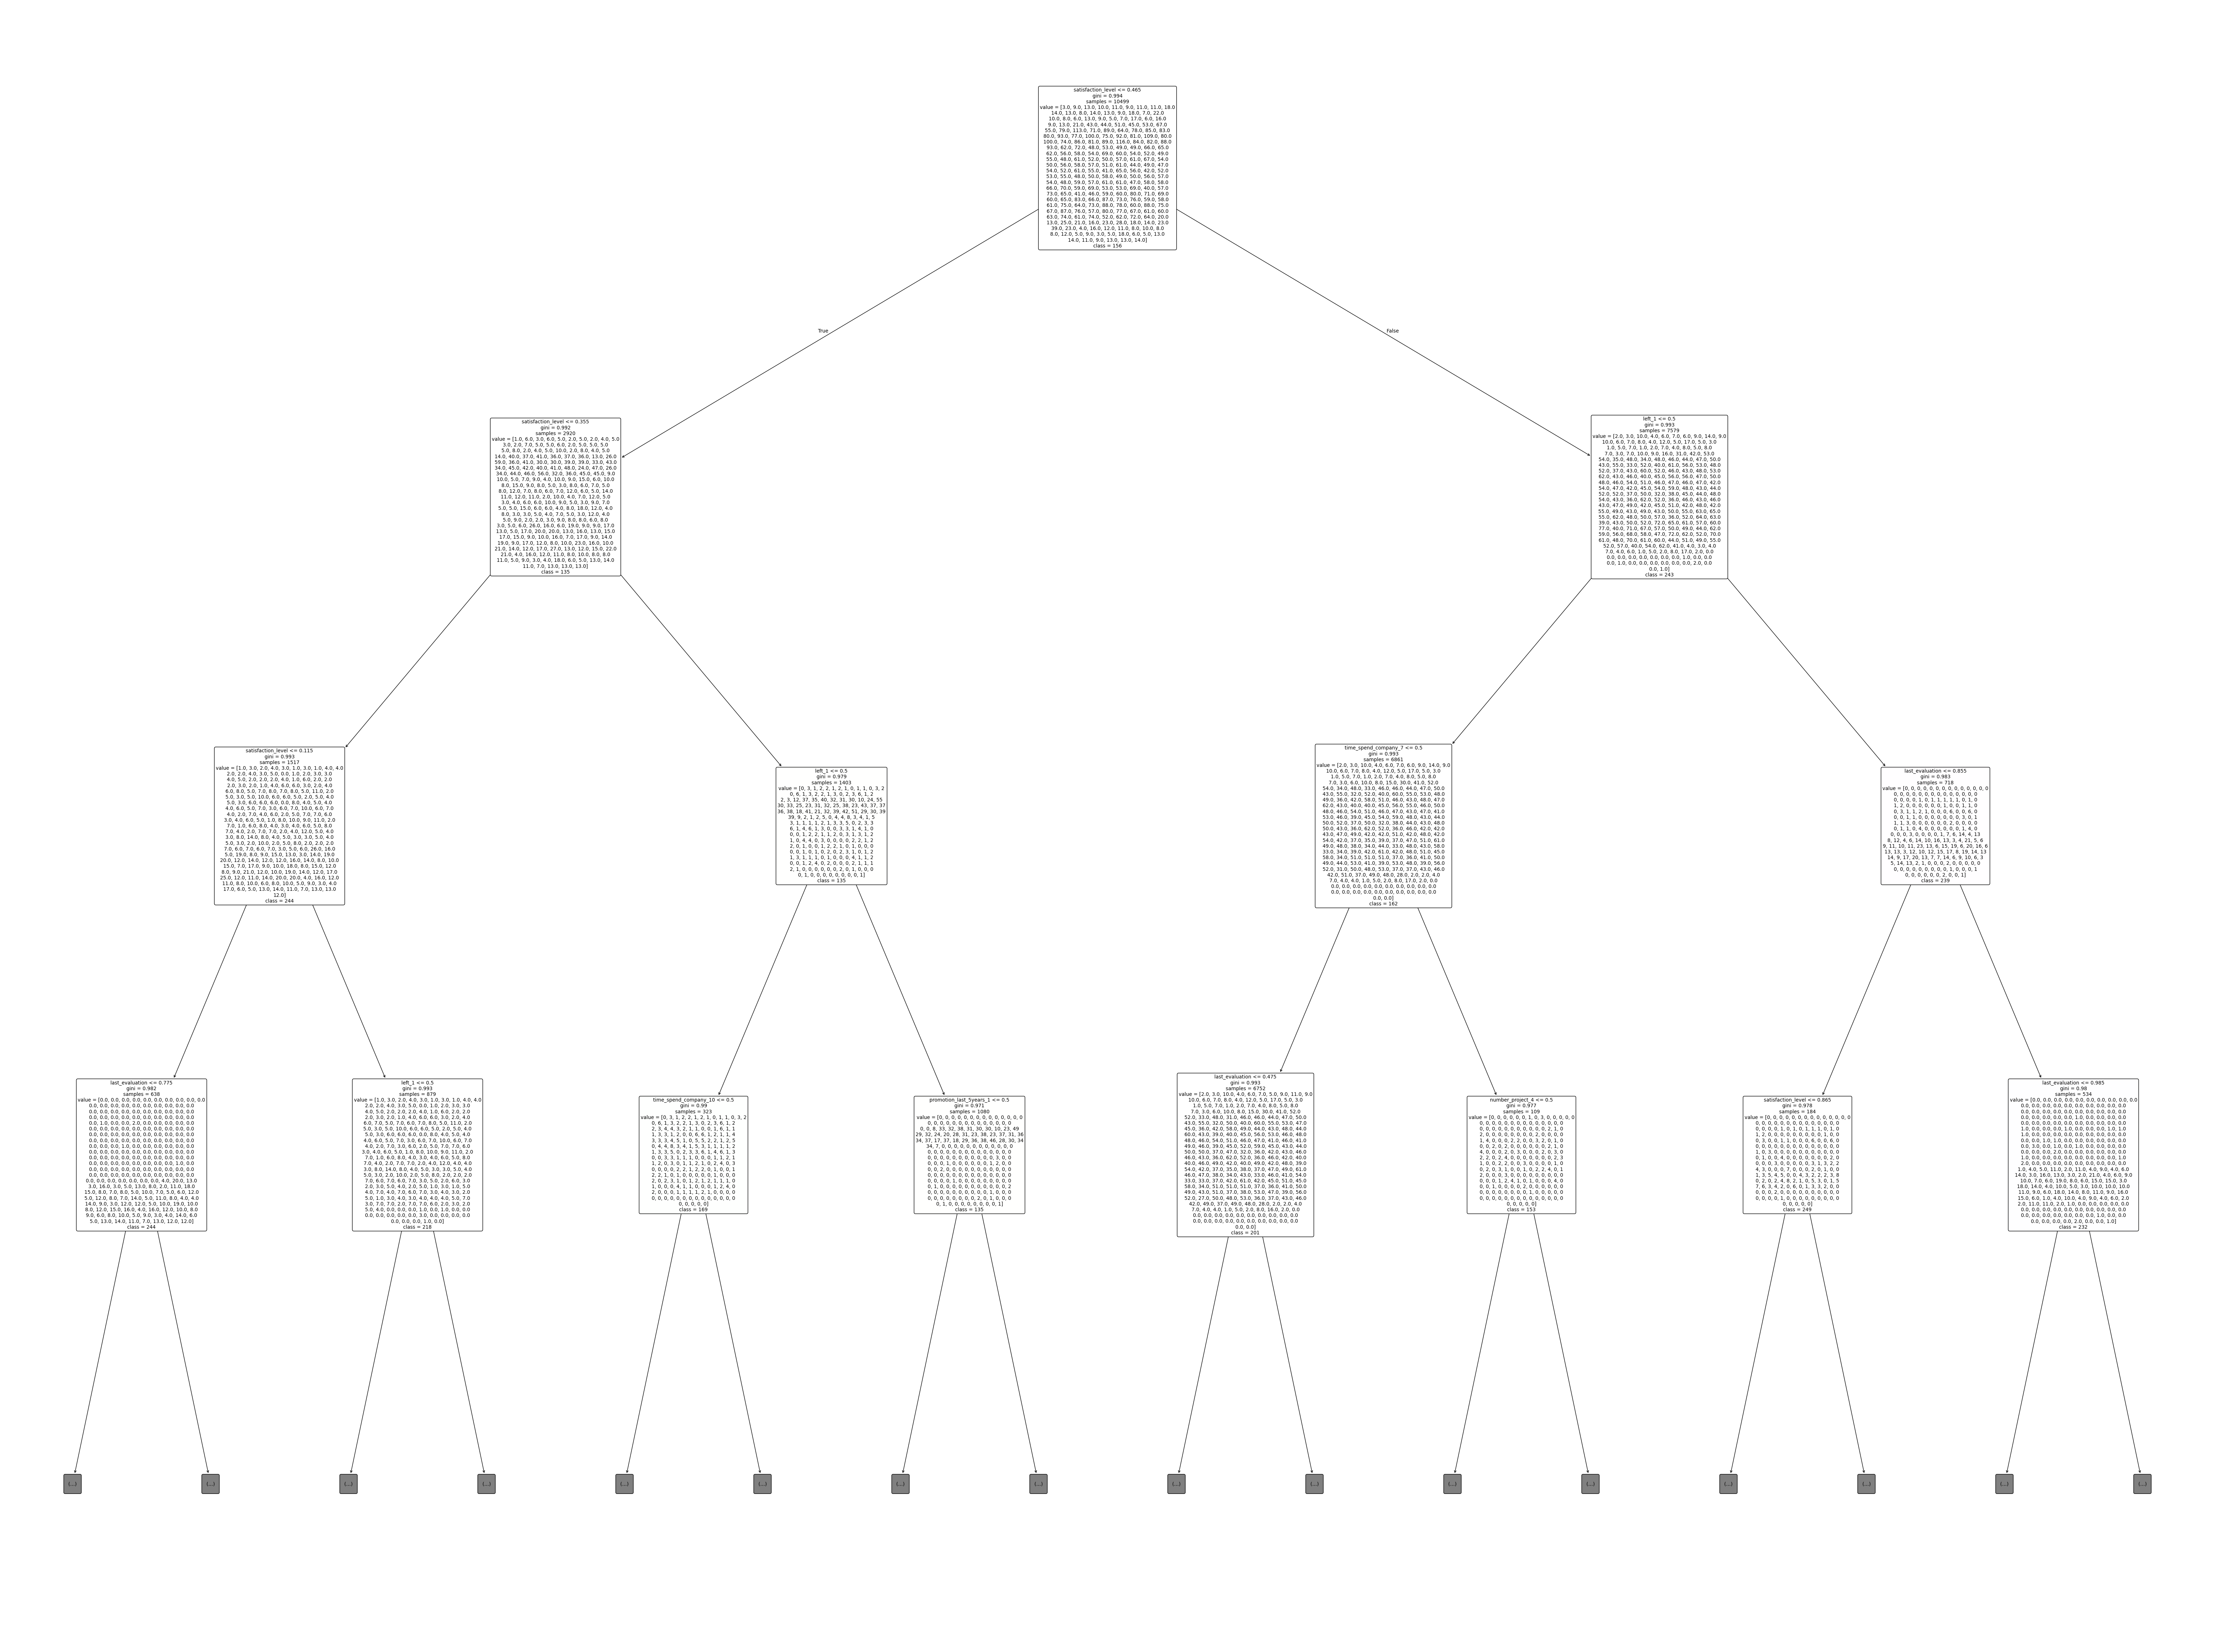

In [159]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True, max_depth=3)
plt.show()